<p>
  <b>AI Lab: Deep Learning for Computer Vision</b><br>
  <b><a href="https://www.wqu.edu/">WorldQuant University</a></b>
</p>

<div class="alert alert-success" role="alert">
  <p>
    <center><b>Usage Guidelines</b></center>
  </p>
  <p>
    This file is licensed under <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International</a>.
  </p>
  <p>
    You <b>can</b>:
    <ul>
      <li><span style="color: green">✓</span> Download this file</li>
      <li><span style="color: green">✓</span> Post this file in public repositories</li>
    </ul>
    You <b>must always</b>:
    <ul>
      <li><span style="color: green">✓</span> Give credit to <a href="https://www.wqu.edu/">WorldQuant University</a> for the creation of this file</li>
      <li><span style="color: green">✓</span> Provide a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">link to the license</a></li>
    </ul>
    You <b>cannot</b>:
    <ul>
      <li><span style="color: red">✗</span> Create derivatives or adaptations of this file</li>
      <li><span style="color: red">✗</span> Use this file for commercial purposes</li>
    </ul>
  </p>
  <p>
    Failure to follow these guidelines is a violation of your terms of service and could lead to your expulsion from WorldQuant University and the revocation your certificate.
  </p>
</div>

### Getting Ready

Let's get ready for this lesson by importing the packages we need.

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import PIL
import torch
import torchvision
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets

Next, we'll print out the version numbers for our libraries, including Python. We want to make sure that anyone who reviews our work knows exactly what software we used in case they want to reproduce our analysis.

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("PIL version : ", PIL.__version__)
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)

Platform: linux
Python version: 3.11.0 (main, Nov 15 2022, 20:12:54) [GCC 10.2.1 20210110]
---
PIL version :  10.2.0
torch version :  2.2.2+cu121
torchvision version :  0.17.2+cu121


As we've done in past lessons, we'll also check if GPUs are available. Remember that some computers come with GPUs, which allow for bigger and faster model training. The `cuda` package is used to access GPUs on Linux and Windows machines in PyTorch; `mps` is used on Macs. 

We'll use the `device` variable later to set the location of our data and model.

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


### Initializing MTCNN and Inception-ResNet V1 

Let's start things by initializing MTCNN as we've done in the past lesson. We'll want an MTCNN model that just detects one face.

**Task 4.4.1:** Create a MTCNN model. Make sure to set the image size as 240, `keep_all` to `False`, and`min_face_size` to 40.

In [4]:
mtcnn0 = MTCNN(device = device, keep_all = True, min_face_size = 40, image_size=240, post_process=False)
print(mtcnn0)

MTCNN(
  (pnet): PNet(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
    (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
    (softmax4_1): Softmax(dim=1)
    (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (rnet): RNet(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=28)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=48)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(48, 64,

We'll also initialize the Inception-ResNet V1 model. This model is used for facial recognition. Particularly, we'll be using a model that has been pre-trained on the VGGFace2 dataset. This is a massive dataset of over 3 million images and over 9000 identities.

In [5]:
resnet = InceptionResnetV1(pretrained="vggface2").eval()

### Preparing our Data

We need to prepare our data to make it easy to use the Inception-ResNet V1 model. We'll ultimately create a `DataLoader` object.

**Task 4.4.2:** Create a path object for the path `project4/data/images/`. Use the `Path` class from `pathlib`.

In [6]:
images_folder = Path("project4", "data", "images")

print(f"Path to images: {images_folder}")

Path to images: project4/data/images


The next step is to create an `ImageFolder` object for the path we just created. `ImageFolder` is provided to us by `torchvision` and makes it easier when working with PyTorch.

**Task 4.4.3:** Create an `ImageFolder` object for the path object in the previous task.

In [7]:
dataset = datasets.ImageFolder(images_folder)

print(dataset)

Dataset ImageFolder
    Number of datapoints: 10
    Root location: project4/data/images


With the `ImageFolder` object, each subdirectory of the input path is considered a separate class. The class label is just the name of the subdirectory. In the previous lesson, we pulled out frames for Mary Kom and Ranveer, the interviewer.

**Task 4.4.4:** Print out all subdirectories in `images_folder`. You should use the method `iterdir` of the path object.

In [8]:
for subdirectory in images_folder.iterdir():
    print(subdirectory)

project4/data/images/mary_kom
project4/data/images/ranveer


With a `ImageFolder` object, the `.class_to_idx` is a mapping between class label to class integer.

In [9]:
dataset.class_to_idx

{'mary_kom': 0, 'ranveer': 1}

However, we'd like to create the reverse mapping. In other words, integer to class label.

**Task 4.4.5:** Create a dictionary that maps integer to class label.

In [10]:
idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}

print(idx_to_class)

{0: 'mary_kom', 1: 'ranveer'}


The next step is to create a `DataLoader` object with our `ImageFolder`. These objects are iterables that work well with PyTorch. Remember how we worked with `DataLoader` in past projects. One thing we'll do differently here is provide the `DataLoader` a collate function. In our case, the collate function is returning the first element of a tuple, which is the image object.

In [11]:
def collate_fn(x):
    return x[0]

**Task 4.4.6:** Construct a `DataLoader` object with the previously created `dataset`. Make sure to define the collate function defined above with the keyword argument `collate_fn`.

In [12]:
loader = DataLoader(dataset, collate_fn = collate_fn)

print(loader.dataset)

Dataset ImageFolder
    Number of datapoints: 10
    Root location: project4/data/images


We are ready to start using our facial recognition model. We have a `DataLoader` object that we can iterate over all the images when using the model but let's first see how it's done with just a single image.

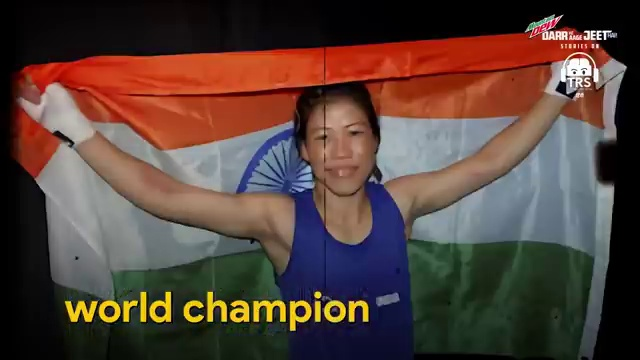

In [13]:
img, _ = iter(loader).__next__()
img

The first step to our facial recognition model is to first detect the faces in the image. We can use MTCNN model like in the previous lesson. From `img`, we only see one person, Mary Kom. So it's fine to use `mtcnn0`, which will only return one detected face.

**Task 4.4.7:** Use `mtcnn0` to detect the face and probability.

In [14]:
face, prob = mtcnn0(img, return_prob=True)

print(type(face))
print(f"Probability of detected face: {prob}")

<class 'torch.Tensor'>
Probability of detected face: [0.9999592304229736]


Looks like we are really certain we have detected a face.

### Running the Inception-ResNet V1 model

The facial recognition model needs a 4D PyTorch tensor of faces. At the moment, we have just one 3D tensor because we only have one face. We can't use the model right away! Let's see what happens if we try.

In [15]:
face = face.squeeze(0)
try:
    resnet(face)
except ValueError as e:
    print(e)

expected 4D input (got 3D input)


**Task 4.4.8:** Print out the shape of our `face` tensor.

In [16]:
print(face.shape)

torch.Size([3, 240, 240])


Indeed, it's not a 4D tensor! We'll need to change the shape of the Tensor for us to make progress.

**Task 4.4.9:** Change the shape of the tensor from `[3, 240, 240]` to `[1, 3, 240, 240]`. You'll need to use the `.unsqueeze` method of the PyTorch tensor.

In [17]:
face_4d = face.unsqueeze(0)

print(face_4d.shape)

torch.Size([1, 3, 240, 240])


Now we can use Inception-ResNet.

In [18]:
embedding = resnet(face_4d)

print(f"Shape of face embedding: {embedding.shape}")

Shape of face embedding: torch.Size([1, 512])


The model returns an embedding for the face using 512 dimensions. The embedding is a vector that represents the features the model extracted. Now we are ready to run our model on all the extracted frames. The process will be:

- Iterate over all images
- Run the face detection model
- If the model returns a result and with a probability of at least 90%, add the embeddings to a dictionary that keeps the embeddings for each person separately.

**Task 4.4.10:** Filter out results in which `face` is `None` or where the probability is less than 0.90.

In [19]:
# Dictionary that maps name to list of their embeddings
name_to_embeddings = {name: [] for name in idx_to_class.values()}

for img, idx in loader:
    faces, probs = mtcnn0(img, return_prob=True)  # faces & probs can have multiple values

    if faces is not None:  # Check if any face is detected
        for face, prob in zip(faces, probs):  # Iterate over multiple faces
            if prob >= 0.9:  # Direct comparison (no need for .item())
                if face.ndimension() == 3:  
                    face = face.unsqueeze(0)  # Ensure shape is [1, 3, H, W]

                emb = resnet(face)  # Get embedding
                name_to_embeddings[idx_to_class[idx]].append(emb)

Since we had several images of Mary Kom and Ranveer, we have several face embeddings for each of them. We'll want to create a single face embedding for each person by taking the average across their embeddings. This average face embedding will be our reference for a person, often called a faceprint in analogy with fingerprints.

The first step is to take our list of face embeddings for a person and create one 2D PyTorch tensor. This can be done with `torch.stack` given our `name_to_embedings` dictionary.

In [20]:
print(name_to_embeddings.keys())
print(type(name_to_embeddings["mary_kom"]))

dict_keys(['mary_kom', 'ranveer'])
<class 'list'>


**Task 4.4.11:** Take the list of embeddings for both Mary and Ranveer and convert each list to a 2D PyTorch tensor by using `torch.stack`. Then print the shapes of the two PyTorch tensors resulting from the stacking operation.

In [21]:
embeddings_mary = torch.stack(name_to_embeddings['mary_kom'])
embeddings_ranveer = torch.stack(name_to_embeddings['ranveer'])

embeddings_mary_shape = embeddings_mary.shape
embeddings_ranveer_shape = embeddings_ranveer.shape

print(f"Shape of stack of embeddings for Mary: {embeddings_mary_shape}")
print(f"Shape of stack of embeddings for Ranveer: {embeddings_ranveer_shape}")

Shape of stack of embeddings for Mary: torch.Size([5, 1, 512])
Shape of stack of embeddings for Ranveer: torch.Size([5, 1, 512])


Now we can take the average using `torch.mean`.

**Task 4.4.12:** Calculate the average of the stacked embeddings along the zero dimension. Make sure to do this for the embeddings for both Mary Kom and Ranveer. The resulting shape should be a 1x512 tensor.

In [22]:
avg_embedding_mary = torch.mean(embeddings_mary, dim = 0)
avg_embedding_ranveer = torch.mean(embeddings_ranveer, dim = 0)

print(f"Shape of avg_embedding: {avg_embedding_mary.shape}")
print(f"Shape of avg_embedding: {avg_embedding_ranveer.shape}")

Shape of avg_embedding: torch.Size([1, 512])
Shape of avg_embedding: torch.Size([1, 512])


We'll save the embeddings as a list of tuples. The tuples will be in the form of `(average embedding, name)`. Since we have two different people, our list will have length two.

**Task 4.4.13:** Create the list to save the embedding. Use the string `"mary_kom"` and `"ranveer"` for Mary Kom and Ranveer, respectively.

In [23]:
# GRADE ME

In [24]:
embeddings_to_save = [
    (avg_embedding_mary, "mary_kom"),
    (avg_embedding_ranveer, "ranveer"),
]
torch.save(embeddings_to_save, "embeddings.pt")

In the previous code cell, we saved the average embeddings to file. If we need the embedding, we can load it up with `torch.load`. It accepts as its input the path to the saved embedding. We saved it to the current directory with the name `"embeddings.pt"`.

**Task 4.4.14:** Load the face embeddings.

In [26]:
embedding_data = torch.load("embeddings.pt")

names = [name for _, name in embedding_data]
print(f"Loaded the embedding for: {names}")

Loaded the embedding for: ['mary_kom', 'ranveer']


### Inception-ResNet V1 on an Image with One Person

We can consider the embeddings of Mary Kom and Ranveer as our database of known faces. If we now take a new image, we can check if we can recognize whether Mary Kom or Ranveer appear in that image! We'll first focus on one image with only Mary Kom.

**Task 4.4.15:** Create a path object for the image in `project4/data/extracted_frames/frame_100.jpg`.

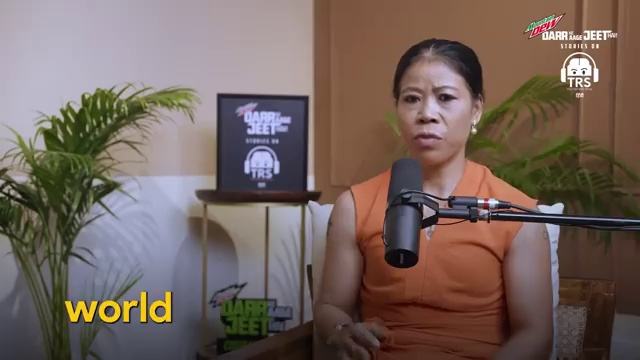

In [27]:
test_img_path = Path("project4", "data", "extracted_frames", "frame_100.jpg")

test_img = Image.open(test_img_path)
test_img

Earlier, we had used `mtcnn0` to just detect one face but let's practice with one that will detect all faces in an image.

In [28]:
mtcnn = MTCNN(image_size=240, keep_all=True, min_face_size=40)
print(f"MTCNN image size: {mtcnn.image_size}")
print(f"MTCNN keeping all faces: {mtcnn.keep_all}")

MTCNN image size: 240
MTCNN keeping all faces: True


**Task 4.4.16:** Run the face detection model `mtcnn` on the selected frame from above. Recall how `mtcnn` was set to find all faces.

In [29]:
img_cropped_list, prob_list = mtcnn0(test_img, return_prob = True)

print(f"Number of detected faces: {len(prob_list)}")
print(f"Probability of detected face: {prob_list[0]}")

Number of detected faces: 1
Probability of detected face: 0.9999531507492065


The code below will then run the face recognition model to get the face embedding.

In [30]:
for i, prob in enumerate(prob_list):
    if prob > 0.90:
        emb = resnet(img_cropped_list[i].unsqueeze(0))

With the embedding we created above, `emb`, we can see how different it's from the average embedding for Mary Kom. Let's compute the distance between `emb` and the two saved embeddings of Mary and Ranveer.

**Task 4.4.17:** Use `torch.dist` to calculate the distance between `emb` and `known_emb`. Make sure that `dist` is a float and not a PyTorch tensor. The calculated distances will be stored in a dictionary.

In [31]:
distances = {}

for known_emb, name in embedding_data:
    dist = torch.dist(emb, known_emb).item()
    distances[name] = dist

closest, min_dist = min(distances.items(), key=lambda x: x[1])
print(f"Closest match: {closest}")
print(f"Calculated distance: {min_dist :.2f}")

Closest match: mary_kom
Calculated distance: 0.09


The smallest distance corresponds to Mary Kom. It makes sense the distance is closer for Mary Kom as that's who is in the image.

We can use `mtcnn.detect` to get the bounding boxes for the faces.

In [32]:
boxes, _ = mtcnn.detect(test_img)
print(f"Shape of boxes tensor: {boxes.shape}")

Shape of boxes tensor: (1, 4)


Now let's draw a box over a face together with the name of its closest known embedding. We'll use a threshold of 0.8. Any detected face with an embedding that is further than this threshold from a known face will remain unrecognized.

In [33]:
threshold = 0.8

**Task 4.4.18:** Recognize Mary Kom's face by drawing a box with her name next to it. Only do so for faces where `min_dist` is smaller than the `threshold`. The code below displays the original image and plots the bounding boxes for the detected faces.

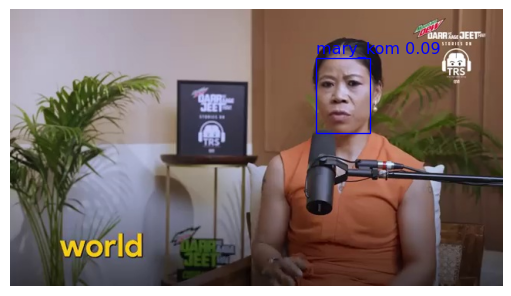

In [34]:
# This sets the image size and draws the original image
width, height = test_img.size
dpi = 96
fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
axis = fig.subplots()
axis.imshow(test_img)
plt.axis("off")

for box in boxes:
    rect = plt.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color="blue"
    )
    axis.add_patch(rect)

    closest, min_dist = min(distances.items(), key=lambda x: x[1])

    # Drawing the box with recognition results

    if min_dist < threshold:
        name = closest
        color = "blue"
    else:
        name = "Unrecognized"
        color = "red"

    plt.text(
        box[0],
        box[1],
        f"{name} {min_dist:.2f}",
        fontsize=12,
        color=color,
        ha="left",
        va="bottom",
    )

plt.axis("off")
plt.show()

Notice how we were able to recognize Mary Kom given our specified threshold!

### Inception-ResNet V1 on an Image With More Than One Person

Now we are ready to run our facial recognition model when there are more than one person in the image. We have chosen the following image.

**Task 4.4.19:** Display the chosen image `project4/data/extracted_frames/frame_210.jpg` using `Image.open`.

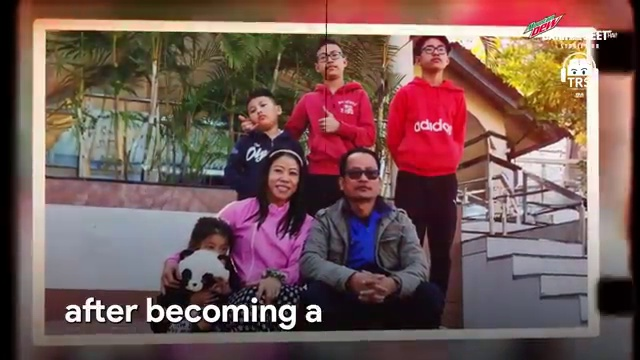

In [35]:
img_multiple_people_path = Path("project4", "data", "extracted_frames", "frame_210.jpg")
img_multiple_people = Image.open(img_multiple_people_path)

img_multiple_people

There's six faces in that image, seven if you count the panda! The function below encapsulates the code we have already written. It accepts the path of an image and it will draw boxes over each detected face and indicate where it was able to recognize any of the two faces from our embeddings we saved earlier. If any face is recognized, the person's name is displayed along with the distance.

In [36]:
def recognize_faces(img_path, embedding_data, mtcnn, resnet, threshold=0.7):
    # Generating the bounding boxes, faces tensors, and probabilities
    image = Image.open(img_path)
    boxes, probs = mtcnn.detect(image)
    cropped_images = mtcnn(image)

    if boxes is None:
        return

    # This sets the image size and draws the original image
    width, height = image.size
    dpi = 96
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    axis = fig.subplots()
    axis.imshow(image)
    plt.axis("off")

    # Iterating over each face and comparing it against the pre-calculated embeddings
    # from our "database"
    for box, prob, face in zip(boxes, probs, cropped_images):
        if prob < 0.90:
            continue

        # Draw bounding boxes for all detected faces
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False,
            color="blue",
        )
        axis.add_patch(rect)

        # Find the closest face from our database of faces
        emb = resnet(face.unsqueeze(0))
        distances = {}
        for known_emb, name in embedding_data:
            dist = torch.dist(emb, known_emb).item()
            distances[name] = dist

        closest, min_dist = min(distances.items(), key=lambda x: x[1])

        # Drawing the box with recognition results
        name = closest if min_dist < threshold else "Unrecognized"
        color = "red" if name == "Unrecognized" else "blue"
        label = f"{name} {min_dist:.2f}"

        axis.text(box[0], box[1], label, fontsize=8, color=color)

    plt.axis("off")
    plt.show()

With the function defined, it's time to use it.

In [ ]:
recognize_faces(img_multiple_people_path, embedding_data, mtcnn, resnet)

Looks like the model failed to recognize anyone. Keep in mind this video frame is showing a photo of Mary Kom's family. It might be having difficulty for this reason.

**Task 4.4.20:** Run `recognize_faces` but use a higher threshold of 0.9.

In [ ]:
recognize_faces(img_multiple_people_path, embedding_data, mtcnn, resnet, threshold = 0.9)

Now we recognize Mary Kom. However, we have a false positive as the model thinks Mary Kom's daughter is Ranveer.

---
This file &#169; 2024 by [WorldQuant University](https://www.wqu.edu/) is licensed under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/).